<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Let's-set-up-some-common-file-paths" data-toc-modified-id="Let's-set-up-some-common-file-paths-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Let's set up some common file paths</a></span></li></ul></li><li><span><a href="#Behavior" data-toc-modified-id="Behavior-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Behavior</a></span><ul class="toc-item"><li><span><a href="#Extract-sync-time-stamps" data-toc-modified-id="Extract-sync-time-stamps-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extract sync time stamps</a></span></li><li><span><a href="#Extract-some-trial-features-so-we-can-analyze-all-of-this-neural-data..." data-toc-modified-id="Extract-some-trial-features-so-we-can-analyze-all-of-this-neural-data...-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract some trial features so we can analyze all of this neural data...</a></span></li></ul></li><li><span><a href="#Spikes" data-toc-modified-id="Spikes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spikes</a></span><ul class="toc-item"><li><span><a href="#Turn-spike-times-into-trains-and-firing-rates" data-toc-modified-id="Turn-spike-times-into-trains-and-firing-rates-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Turn spike times into trains and firing rates</a></span></li><li><span><a href="#Chop-1-kHz-spike-data-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior" data-toc-modified-id="Chop-1-kHz-spike-data-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Chop 1 kHz spike data into trials and downsample, aligned to event timestamps extracted from behavior</a></span></li></ul></li><li><span><a href="#LFP" data-toc-modified-id="LFP-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LFP</a></span><ul class="toc-item"><li><span><a href="#Bandpass-and-smooth-LFP-in-standard-frequency-windows" data-toc-modified-id="Bandpass-and-smooth-LFP-in-standard-frequency-windows-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Bandpass and smooth LFP in standard frequency windows</a></span></li><li><span><a href="#Chop-bandpassed-LFP-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior" data-toc-modified-id="Chop-bandpassed-LFP-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Chop bandpassed LFP into trials and downsample, aligned to event timestamps extracted from behavior</a></span></li><li><span><a href="#Extract-some-trial-features-so-we-can-analyze-all-of-this-neural-data..." data-toc-modified-id="Extract-some-trial-features-so-we-can-analyze-all-of-this-neural-data...-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Extract some trial features so we can analyze all of this neural data...</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Let's-check-out-spikes-synced-to-the-start-of-the-trial" data-toc-modified-id="Let's-check-out-spikes-synced-to-the-start-of-the-trial-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Let's check out spikes synced to the start of the trial</a></span></li></ul></li></ul></div>

Skeleton for final project...

# Setup

## Let's set up some common file paths

In [206]:
import mat73
from os.path import join as pjoin
import glob

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage as ndimage

import dask.array as da

In [2]:
data_dir = "data_clean"
session = "George00_rec14_01282021"

bhv_fnames = sorted(glob.glob(pjoin(data_dir, session + "*bhv*"))) # could be >1
spk_fname = glob.glob(pjoin(data_dir, session + "*units*")) # expect 1
lfp_fname = glob.glob(pjoin(data_dir, session + "*LFP*")) # expect 1

# Behavior

## Extract sync time stamps

For each session, we want to pull out snippets around task events. Two standard sync points are the start (pictures are displayed on the screen) and end (animal makes a selection with a lever movement) of each trial. This function could be customized easily-- we just need a vector of time stamps (in seconds) to align the neural data.

In [3]:
def load_raw_bhv(bhv_fnames):
    """
    Load raw bhv (.bhv2 saved as .mat) into dict; consolidate 
    if split across multiple files (assume alpha order)
    
    Parameters:
    ----------
    bhv_fnames : list 
        File path(s) for behavior data
        
    Returns:
    -------
    bhv_data : dict
        All task data
        
    """
    
    bhv_data = defaultdict(list)
    
    for f in bhv_fnames:
        print(f)
        data = mat73.loadmat(f)

        data_vars = data["bhvdata"].keys()
        for v in data_vars:
            bhv_data[v] += data["bhvdata"][v]
            
    return bhv_data

def load_pl2_codes(spk_fname):
    """
    Load task event codes and corresponding time stamps from 
    raw spk (.pl2 saved as .mat).
    
    Parameters:
    ----------
    spk_fname : list
        File path for spk data; expected length 1
    
    Returns:
    -------
    pl2_codes : dict
        Event codes and timestamps from whole session
    
    """
    
    pl2_codes = mat73.loadmat(spk_fname[0], \
                              only_include=["event_codes", "event_ts"])
    
    return pl2_codes

In [4]:
def get_trial_events(bhv_data, pl2_codes, event):
    """
    For each trial in bhv_data, pull time for this event code 
    (-1 if doesn't exist)
    
    Parameters:
    ----------
    bhv_data : dict
        All task data
    pl2_codes : dict
        Event codes and timestamps from whole session
    event : int
        Event code word
    
    Returns:
    -------
    timestamps : np vector
        Timestamps corresponding to event within each trial (or -1)
        
    """
    
    # cut up trials by default start and stop codes
    start_code = 9
    stop_code = 18
    
    trial_start = np.where(pl2_codes["event_codes"] == start_code)[0]
    trial_stop = np.where(pl2_codes["event_codes"] == stop_code)[0]
    
    # check that we have the same number of trials from bhv and pl2 data
    ntr = len(bhv_data["Trial"])
    if trial_start.shape[0] != ntr or trial_stop.shape[0] != ntr:
        raise ValueError("oops! mismatched bhv2 and pl2 trial counts")
    
    # cycle through all trials, save event time (if exists)
    timestamps = -1 * np.ones(ntr)
    for tr in range(ntr):
        
        # restrict to event codes in this trial
        codes = pl2_codes["event_codes"][trial_start[tr] : trial_stop[tr]]
        ts = pl2_codes["event_ts"][trial_start[tr] : trial_stop[tr]]
        
        idx = np.where(codes == event)[0]
        if idx.shape[0] == 1:
            timestamps[tr] = ts[idx]
    
    return timestamps
    

In [5]:
# load bhv data for this session
bhv_data = load_raw_bhv(bhv_fnames)

data_clean/George00_rec14_01282021-bhv_A.mat
data_clean/George00_rec14_01282021-bhv_B.mat
data_clean/George00_rec14_01282021-bhv_C.mat


In [6]:
# load spk events for this session
pl2_codes = load_pl2_codes(spk_fname)

(array([863.,  77.,  70.,  70.,  75.,  67.,  52.,  51.,  49.,  43.]),
 array([-1.00000000e+00,  7.05580460e+02,  1.41216092e+03,  2.11874138e+03,
         2.82532184e+03,  3.53190230e+03,  4.23848276e+03,  4.94506322e+03,
         5.65164368e+03,  6.35822414e+03,  7.06480460e+03]),
 <BarContainer object of 10 artists>)

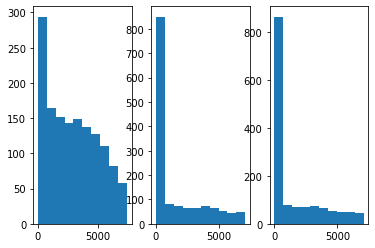

In [7]:
# get time stamps for pictures and lever responses
ts_pics = get_trial_events(bhv_data, pl2_codes, 20)
ts_left = get_trial_events(bhv_data, pl2_codes, 23)
ts_right = get_trial_events(bhv_data, pl2_codes, 24)

fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
ax.hist(ts_pics)

ax = fig.add_subplot(1, 3, 2)
ax.hist(ts_left)

ax = fig.add_subplot(1, 3, 3)
ax.hist(ts_right)

## Extract some trial features so we can analyze all of this neural data...

# Spikes

## Turn spike times into trains and firing rates

The raw data contains spike times at 40 kHz for each neuron. While this is an efficient way to store data, it's often more convenient to visualize/to analyses on spike trains (e.g. 0 0 1 1 0 0 1 0) or smoothed firing rates (trains with 50ms boxcar smoothing) at 1 kHz.

In [224]:
def process_raw_spk(spk_fname):
    """
    Load raw spk (.pl2 saved as .mat)
    
    Parameters:
    ----------
    spk_fname : list
        Contains path file for raw spk data; expect 1
        
    Returns:
    -------
    raster : np array
        spike trains, nunits x ntimes 
    fr : np array
        firing rates, nunits x ntimes
    unit_meta : pd table
        meta data; each row corresponds to row in raster and fr

    """
    
    # load spk data
    data = mat73.loadmat(spk_fname[0])

    # get unique unit names
    unit_names = [u[0] for u in data["unit_names"]]
    nunits = len(unit_names)
    
    # get last spike time in entire session, +1 second
    last_spk = [data[u][-1] for u in unit_names]
    max_t = 1 + max(last_spk) 
    ts = np.arange(np.round(1000 * max_t)) # ms, corresponding time vector 
    ntimes = len(ts)
    
    # get spike trains for all units
    raster = get_raster(data, unit_names, ntimes)
    
    # smooth spike trains into firig rates
    fr = get_fr(raster)
     
    # save some meta data for each unit
    mean_fr = [len(data[u])/max_t for u in unit_names]
    channel = [int(u.replace("SPK_SPKC","")[:3]) for u in unit_names]
    unit_meta = pd.DataFrame({"ID" : unit_names,
                              "channel" : channel,
                              "mean_fr" : mean_fr})
    
    return raster, fr, unit_meta
    
def get_raster(data, unit_names, ntimes):
    nunits = len(unit_names)
    raster = np.empty((nunits, ntimes))
    for u in range(nunits):
        raster[u, :] = ts_to_train(data[unit_names[u]], ntimes)
        
    return raster


def get_fr(raster):
    
    fr = np.empty(raster.shape)
    for u in range(raster.shape[0]):
        fr[u, :] = train_to_fr(raster[u, :])
    
    return fr


def ts_to_train(timestamps, ntimes):
    """
    Turn spike timestamps into a spike train.
    
    Parameters:
    ----------
    timestamps : np vector
        Times this unit fired, in sec
    ntimes : int
        Max time index
        
    Returns:
    -------
    train : np vector
        1 or 0 to indicate spike in that time window
   
    """

    # make train of same size
    train = np.zeros((1, ntimes))
    
    # set train = 1 at closest time stamp
    timestamps_ms = np.round(1000 * timestamps).astype(int)
    train[:, timestamps_ms] = 1
    
    return train


def train_to_fr(train):
    """
    Turn spike train into firing rate.
    
    Parameters:
    ----------
    train : np vector
        1 or 0 to indicate spike in that time window
        
    Returns:
    -------
    train_smoothed : np vector
        train with 50 ms boxcar smoothing
        
    """
    # define boxcar smooth
    box = signal.boxcar(49) / 49
    
    # apply smoothing
    train_smoothed = np.convolve(train, box, "same")
    
    return train_smoothed


In [225]:
%%time
raster, fr, unit_meta = process_raw_spk(spk_fname)

CPU times: user 29 s, sys: 12.1 s, total: 41.1 s
Wall time: 43.6 s


## Chop 1 kHz spike data into trials and downsample, aligned to event timestamps extracted from behavior

Using the time stamps pulled from the behavior, we can look at the same time period across all trials synced to specific events (e.g. start or end of trial).

In [230]:
def chop(long_brain, sync_points, window):
    """
    Chop up 2 hr session into snippets around sync points.
    
    Parameters:
    ----------
    long_brain : 2D np array
        units x time (e.g. spike train, LFP magnitude)
    sync_points : np vector
        sync points across session, e.g. start time for all trials
    window : tuple (2 element)
        time window around sync point (in seconds)

    Returns:
    -------
    chopped_brain : 3D np array
        sync_points x time x units
        
    """
    # number of units
    nunits = long_brain.shape[0]
    
    # time window index
    t_idx = np.arange(window[0] * 1000, window[1] * 1000) # use ms!
    nt = t_idx.shape[0]
    
    # sync point index
    sync_idx = np.round(sync_points * 1000) # use ms!
    sync_idx[sync_idx == -1000] = -1 # manual fix; these trials are missing events
    nsync = sync_idx.shape[0]
    
    # make index matrix
    tile_time = np.tile(t_idx.reshape(1, -1), (nsync, 1))
    tile_sync = np.tile(sync_idx.reshape(-1, 1), (1, nt))
    
    long_idx = (tile_time + tile_sync).astype(int)
    long_idx[tile_sync == -1] = -1 # same manual fix
    
    # chop up each unit...
    chopped_brain = np.empty((nsync, nt, nunits))
    for u in range(nunits):
        chopped_brain[:, :, u] = long_brain[u, :][long_idx]
    
    return chopped_brain
    

In [347]:
%%time
train_chopped = chop(raster, ts_pics, (-2, 2))
fr_chopped = chop(fr, ts_pics, (-2, 2))

CPU times: user 26.3 s, sys: 19.9 s, total: 46.2 s
Wall time: 54 s


# LFP

## Bandpass and smooth LFP in standard frequency windows


## Chop bandpassed LFP into trials and downsample, aligned to event timestamps extracted from behavior

# Visualization

## Let's check out spikes synced to the start of the trial

In [ ]:
fun_units = [40, 43, 53, 96, 69]

fig = plt.figure(figsize=(8, 10))

t_idx = np.arange(-2000, 2000)

for u in range(len(fun_units)):
    ax = fig.add_subplot(5, 1, u + 1)
    ax.plot(t_idx, 1000*np.mean(fr_chopped[:, :, fun_units[u]], axis=0))
    
    y = ax.get_ylim()
    new_y = (0, y[1])
    
    ax.plot(np.array([0, 0]), new_y, "k")
    ax.plot(np.array([-750, -750]), new_y, "k:")

ax.set_xlabel("Time from sync (ms)")
ax.set_ylabel("Firing rate (Hz)")